<a href="https://colab.research.google.com/github/sahilkhan03/CNN-models/blob/master/hackerearth_gala_inceptionresnetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

TensorFlow 2.x selected.
Tensorflow version 2.1.0
Running on TPU  ['10.122.95.250:8470']
INFO:tensorflow:Initializing the TPU system: 10.122.95.250:8470


INFO:tensorflow:Initializing the TPU system: 10.122.95.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
import re, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage import io, transform
AUTO = tf.data.experimental.AUTOTUNE

In [0]:
GCS_PATH = 'gs://kds-8cc2040a8716afca3a569d7f006b591c76891b9d20270dd549642f5a'
filenames = tf.io.gfile.glob(GCS_PATH+'/train*')
test_files = tf.io.gfile.glob(GCS_PATH+'/test*')

Learning rate schedule: 1e-05 to 4e-05 to 1e-05


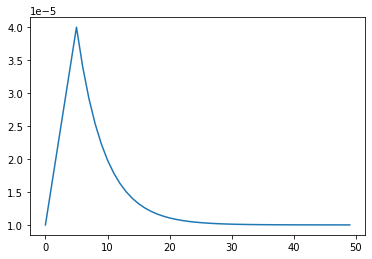

In [4]:
EPOCHS = 50
IMAGE_SIZE = [256, 256]
CLASSES = ['Attire','Decorationandsignage','Food','misc']
INVERSE_CLASSES = {'Attire' : 0,'Decorationandsignage' : 1,'Food' : 2,'misc' : 3}
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
LR_START = 0.00001
LR_MAX = 0.000005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [0]:
AugParams = {
    'd1' : 50,
    'd2': 80,
    'rotate' : 45,
    'ratio' : 0.3
}

def transform(image, inv_mat, image_shape):

    h, w, c = image_shape
    cx, cy = w//2, h//2

    new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
    new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
    new_zs = tf.ones([h*w], dtype=tf.int32)

    old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
    old_coords_x, old_coords_y = tf.round(old_coords[0, :] + w//2), tf.round(old_coords[1, :] + h//2)

    clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
    clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
    clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)

    old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
    old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
    new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
    new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))

    old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
    new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
    rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
    rotated_image_channel = list()
    for i in range(c):
        vals = rotated_image_values[:,i]
        sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
        rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))

    return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

def random_rotate(image, angle, image_shape):

    def get_rotation_mat_inv(angle):
          #transform to radian
        angle = math.pi * angle / 180

        cos_val = tf.math.cos(angle)
        sin_val = tf.math.sin(angle)
        one = tf.constant([1], tf.float32)
        zero = tf.constant([0], tf.float32)

        rot_mat_inv = tf.concat([cos_val, sin_val, zero,
                                     -sin_val, cos_val, zero,
                                     zero, zero, one], axis=0)
        rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])

        return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform(image, rot_mat_inv, image_shape)


def GridMask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):

    h, w = image_height, image_width
    hh = int(np.ceil(np.sqrt(h*h+w*w)))
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges <0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges <0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

    return mask

def apply_grid_mask(image, image_shape):
    mask = GridMask(image_shape[0],
                    image_shape[1],
                    AugParams['d1'],
                    AugParams['d2'],
                    AugParams['rotate'],
                    AugParams['ratio'])
    
    if image_shape[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)

    return image * tf.cast(mask, tf.uint8)

In [6]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

validation_split = 0.2
split = len(filenames) - int(len(filenames) * validation_split)
TRAINING_FILENAMES = filenames[:split]
VALIDATION_FILENAMES = filenames[split:]
TRAIN_STEPS = (count_data_items(TRAINING_FILENAMES)//BATCH_SIZE)
VALIDATE_STEPS = (count_data_items(VALIDATION_FILENAMES)//BATCH_SIZE)
print("TRAINING IMAGES: ", count_data_items(TRAINING_FILENAMES), ", STEPS PER EPOCH: ", TRAIN_STEPS)
print("VALIDATION IMAGES: ", count_data_items(VALIDATION_FILENAMES), ", STEPS PER EPOCH: ", VALIDATE_STEPS)
    
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if tf.random.uniform(shape=[], minval=0.0, maxval=1.0) >=0.6:
        image = apply_grid_mask(image, (*IMAGE_SIZE,3))
    return image, label
    
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    class_label = tf.cast(example['class'], tf.int32)
    return image, class_label

def read_unlabeled_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    return image

def force_image_sizes(image, label):
    image = tf.cast(image, tf.float32)/255.
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image, label

def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.map(force_image_sizes, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(5000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALIDATION_FILENAMES)
    dataset = dataset.map(force_image_sizes, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(4096)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset():
    dataset = tf.data.TFRecordDataset(test_files, num_parallel_reads=AUTO)
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    dataset = dataset.map(lambda image: tf.reshape(tf.cast(image, tf.float32)/255., [*IMAGE_SIZE, 3]), num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

TRAINING IMAGES:  4862 , STEPS PER EPOCH:  37
VALIDATION IMAGES:  1121 , STEPS PER EPOCH:  8


In [0]:
training_set = get_training_dataset()
validation_set = get_validation_dataset()

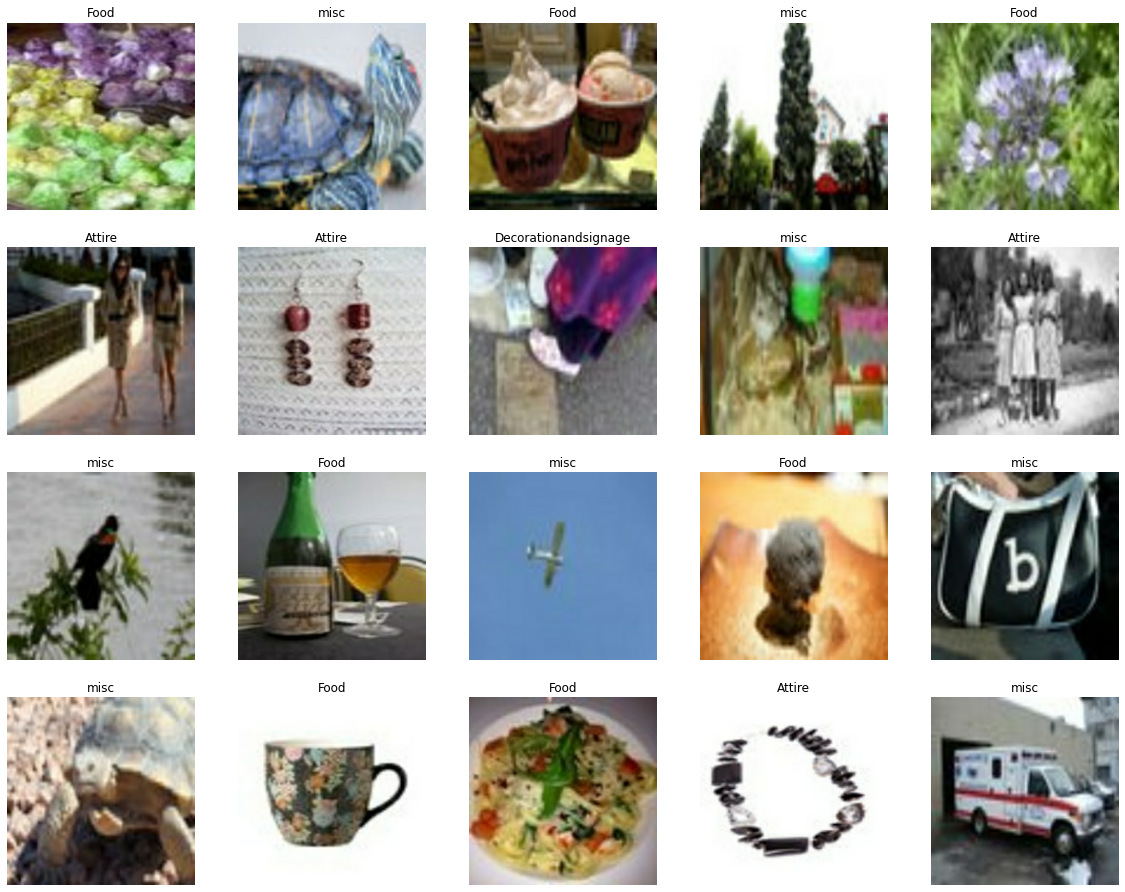

In [8]:
ds = validation_set.unbatch()
i = 0
plt.figure(figsize=(20,20))
for image, label in ds:
      ax = plt.subplot(5,5,i+1)
      plt.imshow(image.numpy())
      plt.title(CLASSES[label])
      plt.axis('off')
      i+=1
      if(i>=20):
        break;

In [0]:
def freeze_model(model, num_trainable_layers):
    if num_trainable_layers == -1:
        for layer in model.layers:
            layer.trainable = True
    else:
        for layer in model.layers[:len(model.layers) - num_trainable_layers]:
            layer.trainable = False
        for layer in model.layers[len(model.layers) - num_trainable_layers:]:
            layer.trainable = True
    for layer in model.layers:
        print(layer, layer.trainable)
    return model

In [10]:
with strategy.scope():
    pretrained_model = tf.keras.applications.InceptionResNetV2(input_shape=[*IMAGE_SIZE, 3],weights='imagenet', pooling='avg' ,include_top=False)
    pretrained_model = freeze_model(pretrained_model, 336)
    model = tf.keras.Sequential([
      pretrained_model,  
      tf.keras.layers.Dense(512, activation = 'relu'),
      tf.keras.layers.Dropout(0.3),  
      tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(
      optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.93),
      loss= tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )    
    
model.summary()

219062272/219055592 [==============================] - 2s 0us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff9b3b7b780> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff9b413a5f8> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7ff9b413a9b0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7ff9b3696438> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff9b35de5f8> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7ff9b1dc37f0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7ff9b1dcc0f0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff9b1dc3438> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7ff9b1d88cf8> False
<tensorflow.python.keras.layers.core.Activation object at 0x7ff9b1d90a58> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object 

In [11]:
len(model.layers[0].layers)

781

In [0]:
callbacks = [#lr_callback, 
             #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.05, mode='auto'),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', mode='min' ,save_best_only=True, 
                                                save_weights_only=True, verbose=1)]

history = model.fit(training_set, validation_data=validation_set, steps_per_epoch=TRAIN_STEPS, 
                    validation_steps = VALIDATE_STEPS, epochs=550, verbose=1, 
                    callbacks=callbacks)

Train for 37 steps, validate for 8 steps
Epoch 1/550


In [0]:
final_accuracy = history.history["val_sparse_categorical_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

In [0]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(history.history['sparse_categorical_accuracy'][1:], history.history['val_sparse_categorical_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [0]:
test_images_ds = get_test_dataset()
print('Computing predictions...')
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

In [0]:
print('Generating submission.csv file...')
test_set = pd.read_csv('test.csv').values.flatten()
ans = np.array([CLASSES[i] for i in predictions])
submission = np.column_stack((test_set,ans))
submission = pd.DataFrame({'Image': submission[:, 0], 'Class': submission[:, 1]})
submission.to_csv('submission.csv', index=False, header=True)
print('Done')

In [0]:
model.load_weights('best_model.h5')
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

In [0]:
print('Generating submission.csv file...')
ans = np.array([CLASSES[i] for i in predictions])
submission = np.column_stack((test_set,ans))
submission = pd.DataFrame({'Image': submission[:, 0], 'Class': submission[:, 1]})
submission.to_csv('submission_best.csv', index=False, header=True)
print('Done')